## Generative pretrained image priors for MRI reconstruction
**Creator**: [Guanxiong Luo](mailto:guanxiong.luo@med.uni-goettingen.de)

**Overview**:
This notebook is to present how to use the pretrained image priors to improve MR reconstruction. What we will use here are the following:
1. a library for generative image prior, called [spreco](https://pypi.org/project/spreco),
2. a MR image reconstruction toolbox, called [BART](https://www.github.com/mrirecon/bart),
3. several pretrained models hosted on this huggingface [page](https://huggingface.co/Guanxiong/MRI-Image-Priors).



#### Let's get all of them at first!

In [ ]:
%%bash
git clone https://github.com/ggluo/spreco
cd spreco
git checkout devel
pip install .
pip install huggingface_hub


#### Prepare BART

In [ ]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart
[ -d "bart" ] && echo "BART was downloaded successfully."

cd bart
make &> /dev/null

In [ ]:
%env TOOLBOX_PATH=/content/bart

In [ ]:
import os
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']

#### Download models

In [8]:
from huggingface_hub import hf_hub_download
files=["config.yaml", "smld.data-00000-of-00001", "smld.index", "smld.meta"]
for file in files:
    hf_hub_download(repo_id="Guanxiong/MRI-Image-Priors", subfolder="Diffusion/SMLD", filename=file, local_dir="./")

#### Create a function to plot the grid of images

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from functools import partial

def subplot(ax, img, title, cmap, interpolation, vmin, vmax):
    ax.imshow(img, cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')


plot_params = {'cmap': 'gray', 'interpolation': 'none', 'vmin': 0}
axplot      = partial(subplot, **plot_params)

#### Generate MR images with the downloaded model

In [1]:
from spreco.common import utils
from spreco.sampler import sampler
import numpy as np

log_path   = './Diffusion/SMLD'
model_path = log_path+'/smld'
config     = utils.load_config(log_path+'/config.yaml')

N=100
sigma_type='quad'
target_snr=0.2
print("INFO -> sigma type: %s, sigma max: %.4f, simga min: %.4f, discrete steps: %d "%( sigma_type, config['sigma_max'], config['sigma_min'], N))

config['N'] = N
a_sampler = sampler(config, target_snr, sigma_type)
a_sampler.init_sampler(model_path, gpu_id='3')

2023-07-16 18:57:42.005237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 18:57:47.759466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
grid_x=5
grid_y=5
samples_n, samples  = a_sampler.pc_sampler(grid_x*grid_y, 3)

images = samples_n[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)

  0%|          | 0/100 [00:00<?, ?it/s]2023-04-05 17:43:31.851933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-05 17:43:31.867270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 100/100 [07:30<00:00,  4.51s/it]


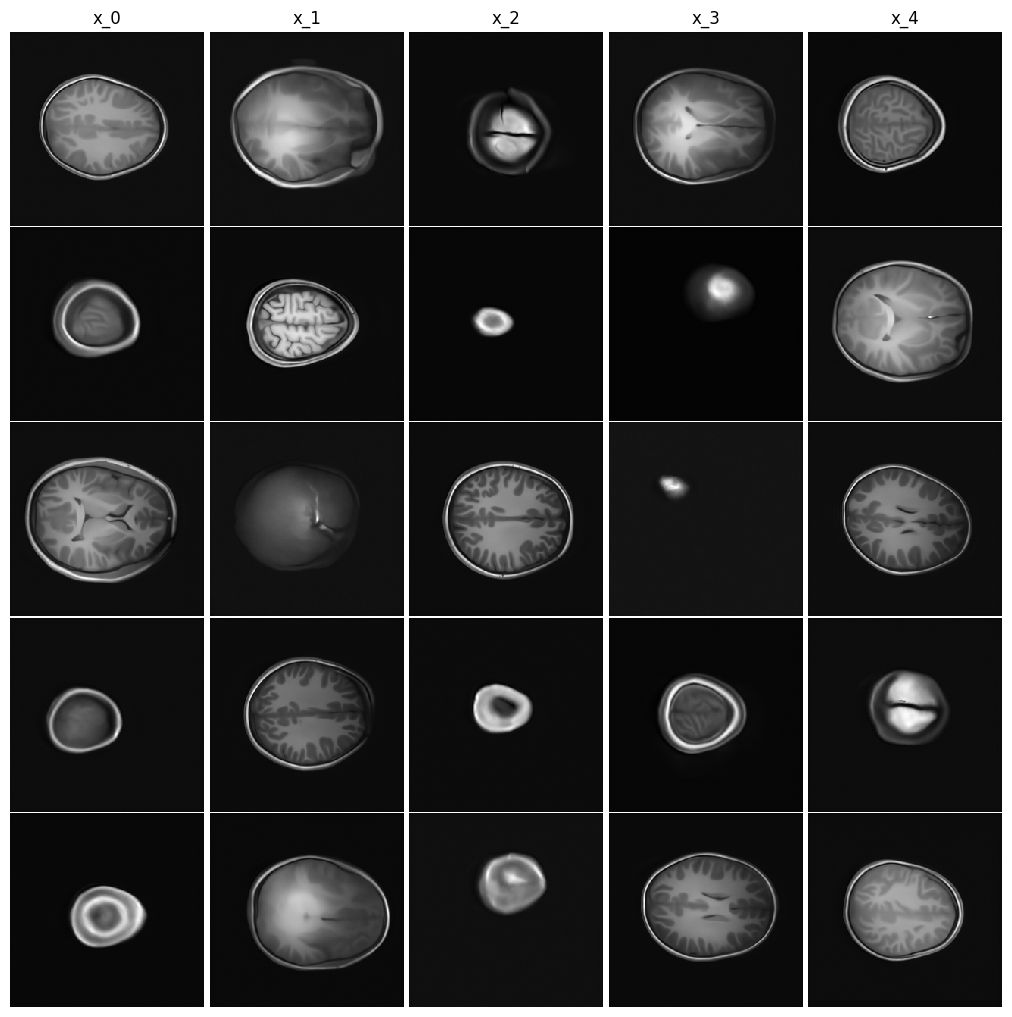

In [7]:
grid_x=5
grid_y=5
a_sampler.steps=3
samples_n, samples  = a_sampler.ancestral_sampler(grid_x*grid_y, 3)

images = samples[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)